In [9]:
!pip install -q fancyimpute

In [10]:
%cd '/content/drive/MyDrive/Colab Notebooks/kaggle/house_pricing'

/content/drive/MyDrive/Colab Notebooks/kaggle/house_pricing


In [11]:
from common import *
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

---
####Read data

In [12]:
x_train, y_train, x_test = read_data()
x_total = pd.concat((x_train, x_test))
x_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [13]:
x_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


---
####Explore column types

In [14]:
columns_cat = x_total.columns[x_total.dtypes == object]
columns_num = x_total.columns[x_total.dtypes != object]

print('Number of numeric features:', len(columns_num))
print('Number of categorical features:', len(columns_cat))

Number of numeric features: 36
Number of categorical features: 43


---
## Explore numeric features

### Distributions

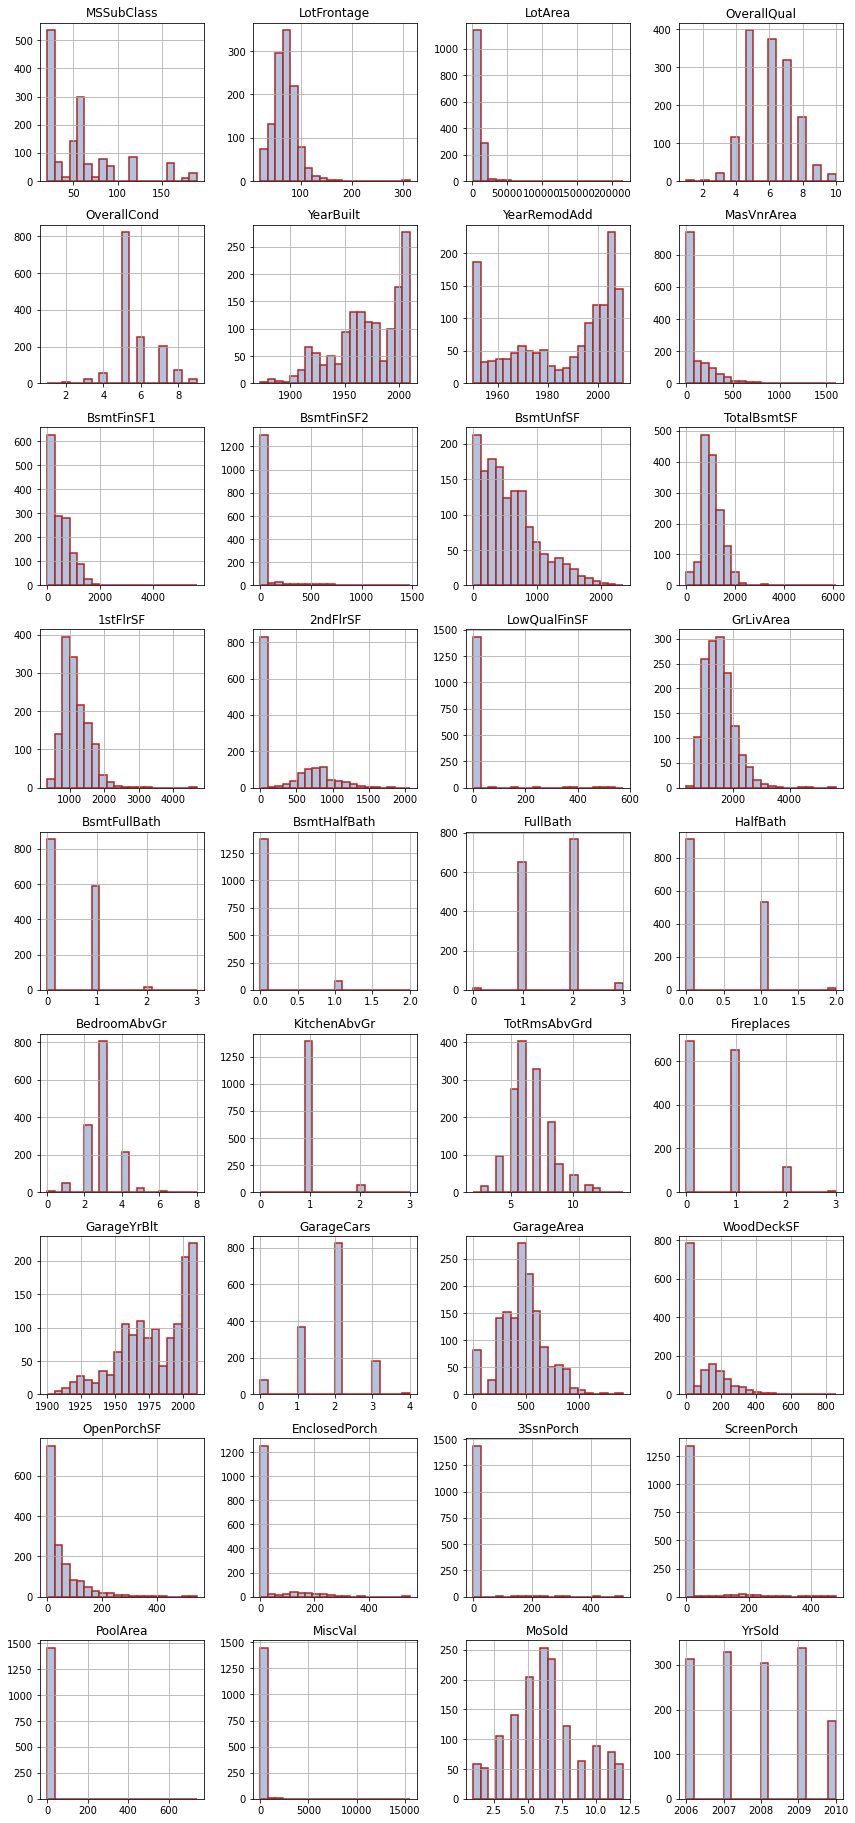

In [15]:
x_train[columns_num].hist(figsize = (12, 28), layout = (10, 4), bins = 20, 
                  color = 'lightsteelblue', edgecolor = 'firebrick', linewidth = 1.5)
plt.tight_layout();

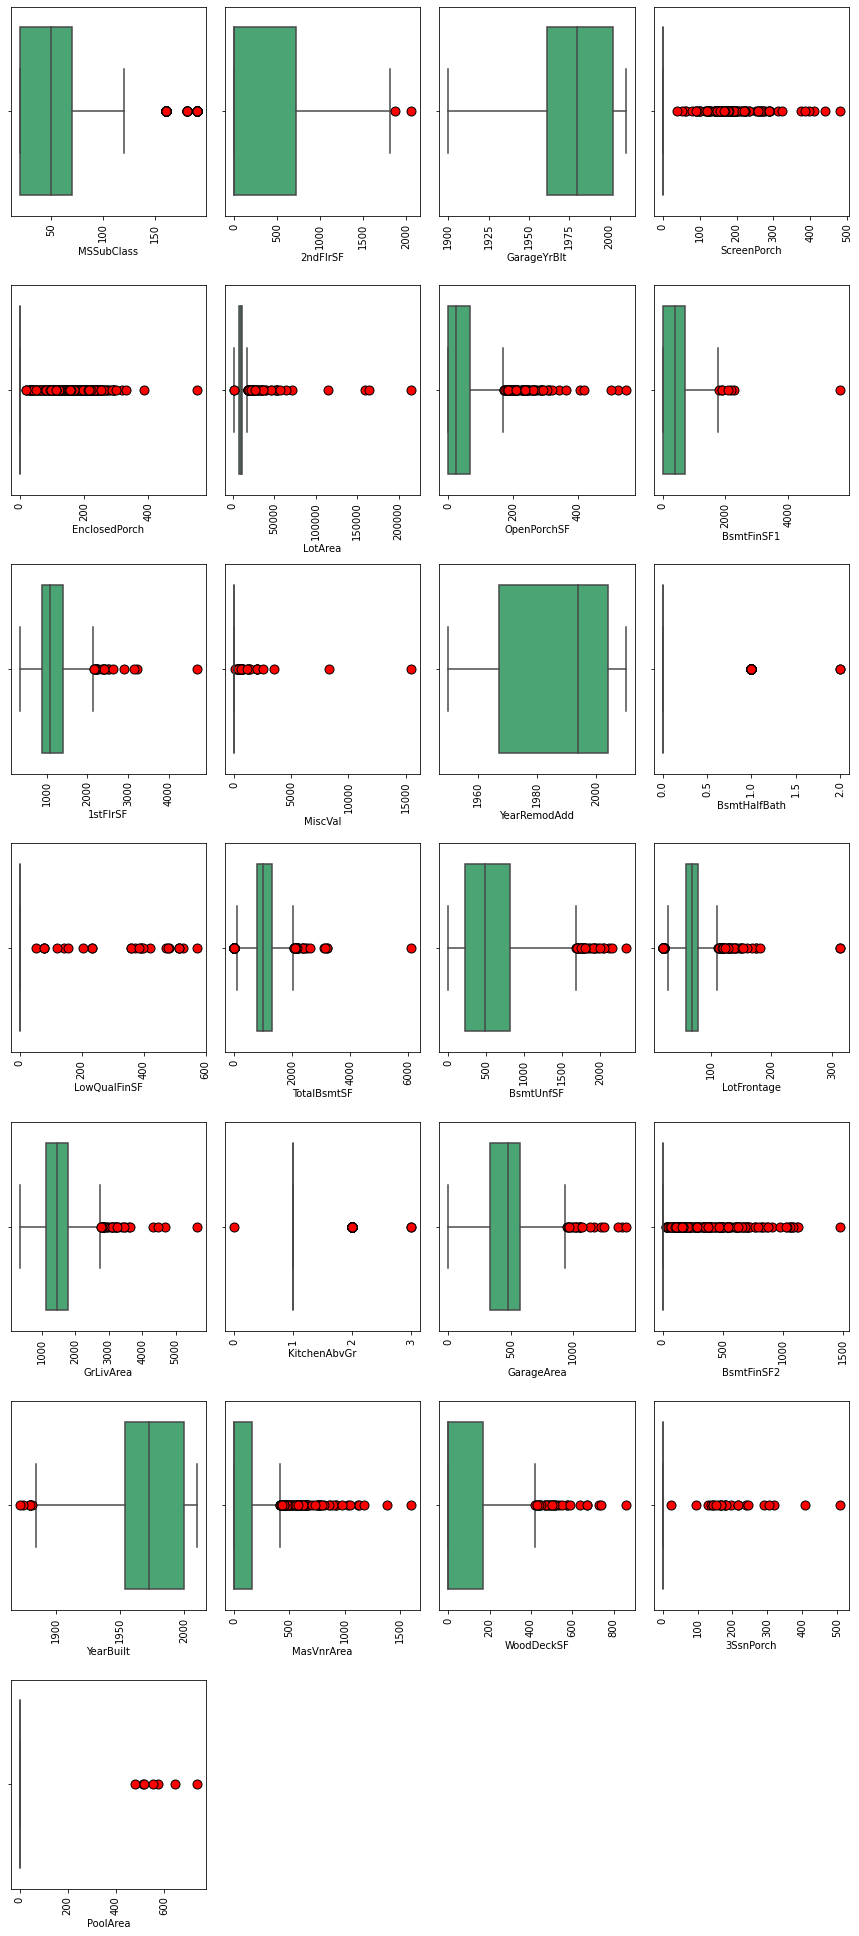

In [16]:
columns_discrete = ['OverallQual', 'OverallCond', 'BsmtFullBath', 'FullBath', 
    'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 
    'MoSold', 'YrSold']
columns_continuous = set(columns_num) - set(columns_discrete)

fig = plt.figure(figsize = (12, 27))
flierprops = dict(marker='o', markerfacecolor = 'r', markeredgecolor = 'k', 
    markersize = 9)

for index, column in enumerate(columns_continuous):
    plt.subplot(7, 4, index + 1)
    sns.boxplot(x=column, data=x_train, color='mediumseagreen', flierprops=flierprops)
    plt.xticks(rotation = 90)
    
fig.tight_layout()

We can observe that:

* Some feautures, such as 'LowQualFinSF' and 'PoolArea', display low variance (or variability), which means that they are close to being constant. Therefore, they do not provide any information to a ML model for learning the patterns in the data and they should be removed,
* Different attributes have different scales and we need to take care of that at the processing stage,
* Most attributes are continuous (e.g. 'LotFrontage'), but there are some discrete ones ('FullBath', 'YrSold', etc.), and
* Most of the attributes suffer from outliers
* For some attributes, the min, max and the interquantile range 'collapse' into a line. That's because these attributes consist of mostly one value (for example, see '3SsnPorch' and 'PoolArea').


### Missing values

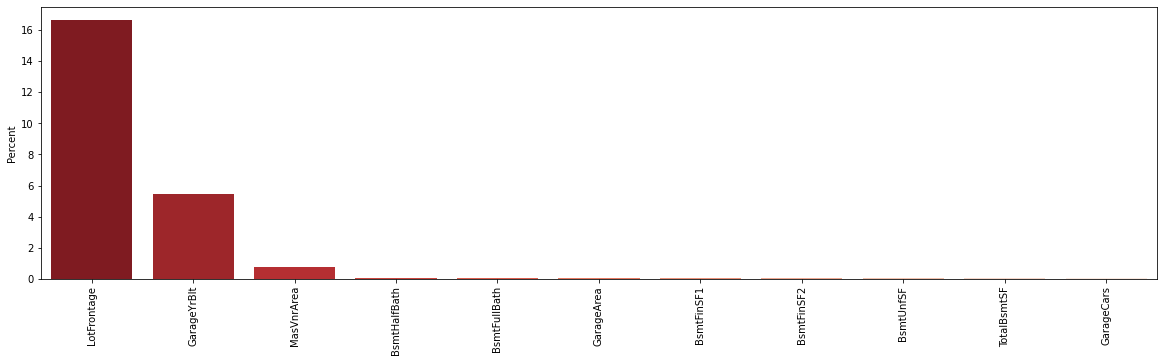

,LotFrontage,GarageYrBlt,MasVnrArea,BsmtHalfBath,BsmtFullBath,GarageArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,GarageCars
Total,486.0000,159.0000,23.0000,2.0000,2.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
Percent,16.6495,5.4471,0.7879,0.0685,0.0685,0.0343,0.0343,0.0343,0.0343,0.0343,0.0343


In [17]:
def missing_percentage(df):
    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


df_missing = missing_percentage(x_total[columns_num])
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=df_missing.index, y='Percent', data=df_missing, palette='Reds_r')
plt.xticks(rotation=90)
plt.show()
pd.set_option('precision', 4)
display(df_missing.T.style.background_gradient(cmap='Reds', axis=1))

### Correlation

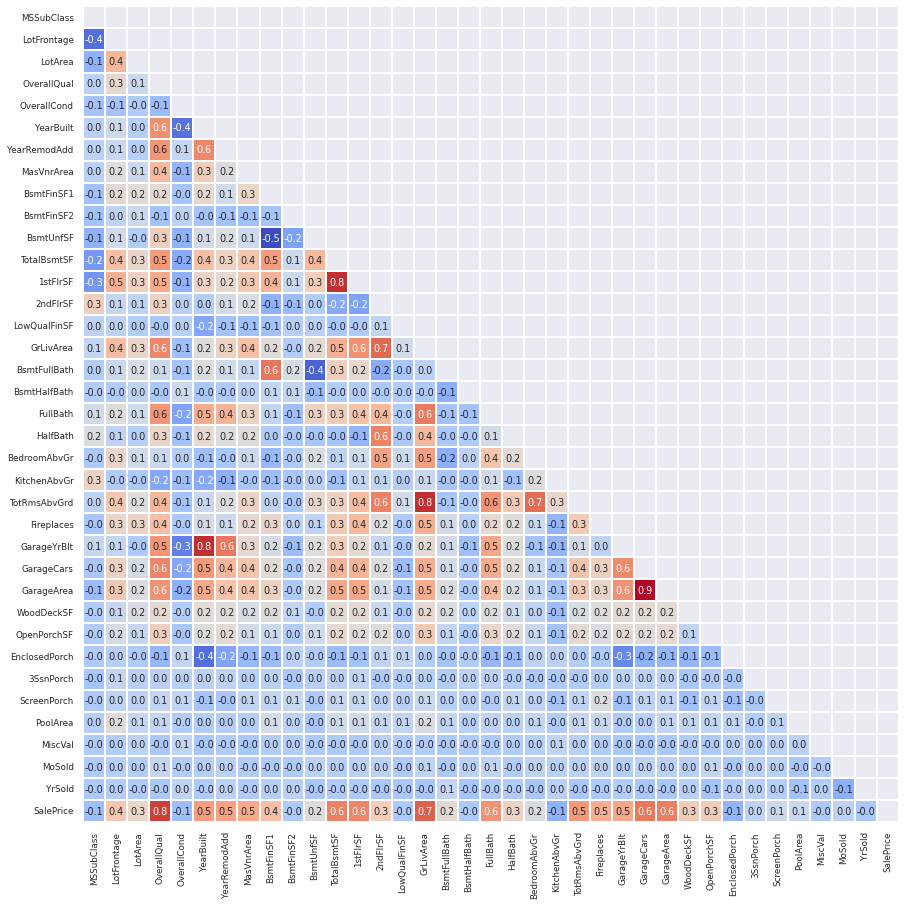

In [18]:
sns.set(font_scale=0.8)
xy_train = x_train.copy()
xy_train['SalePrice'] = y_train
correlation_train = xy_train.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(15, 15))
_ = sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)

---
## Explore categorical features

### Distributions

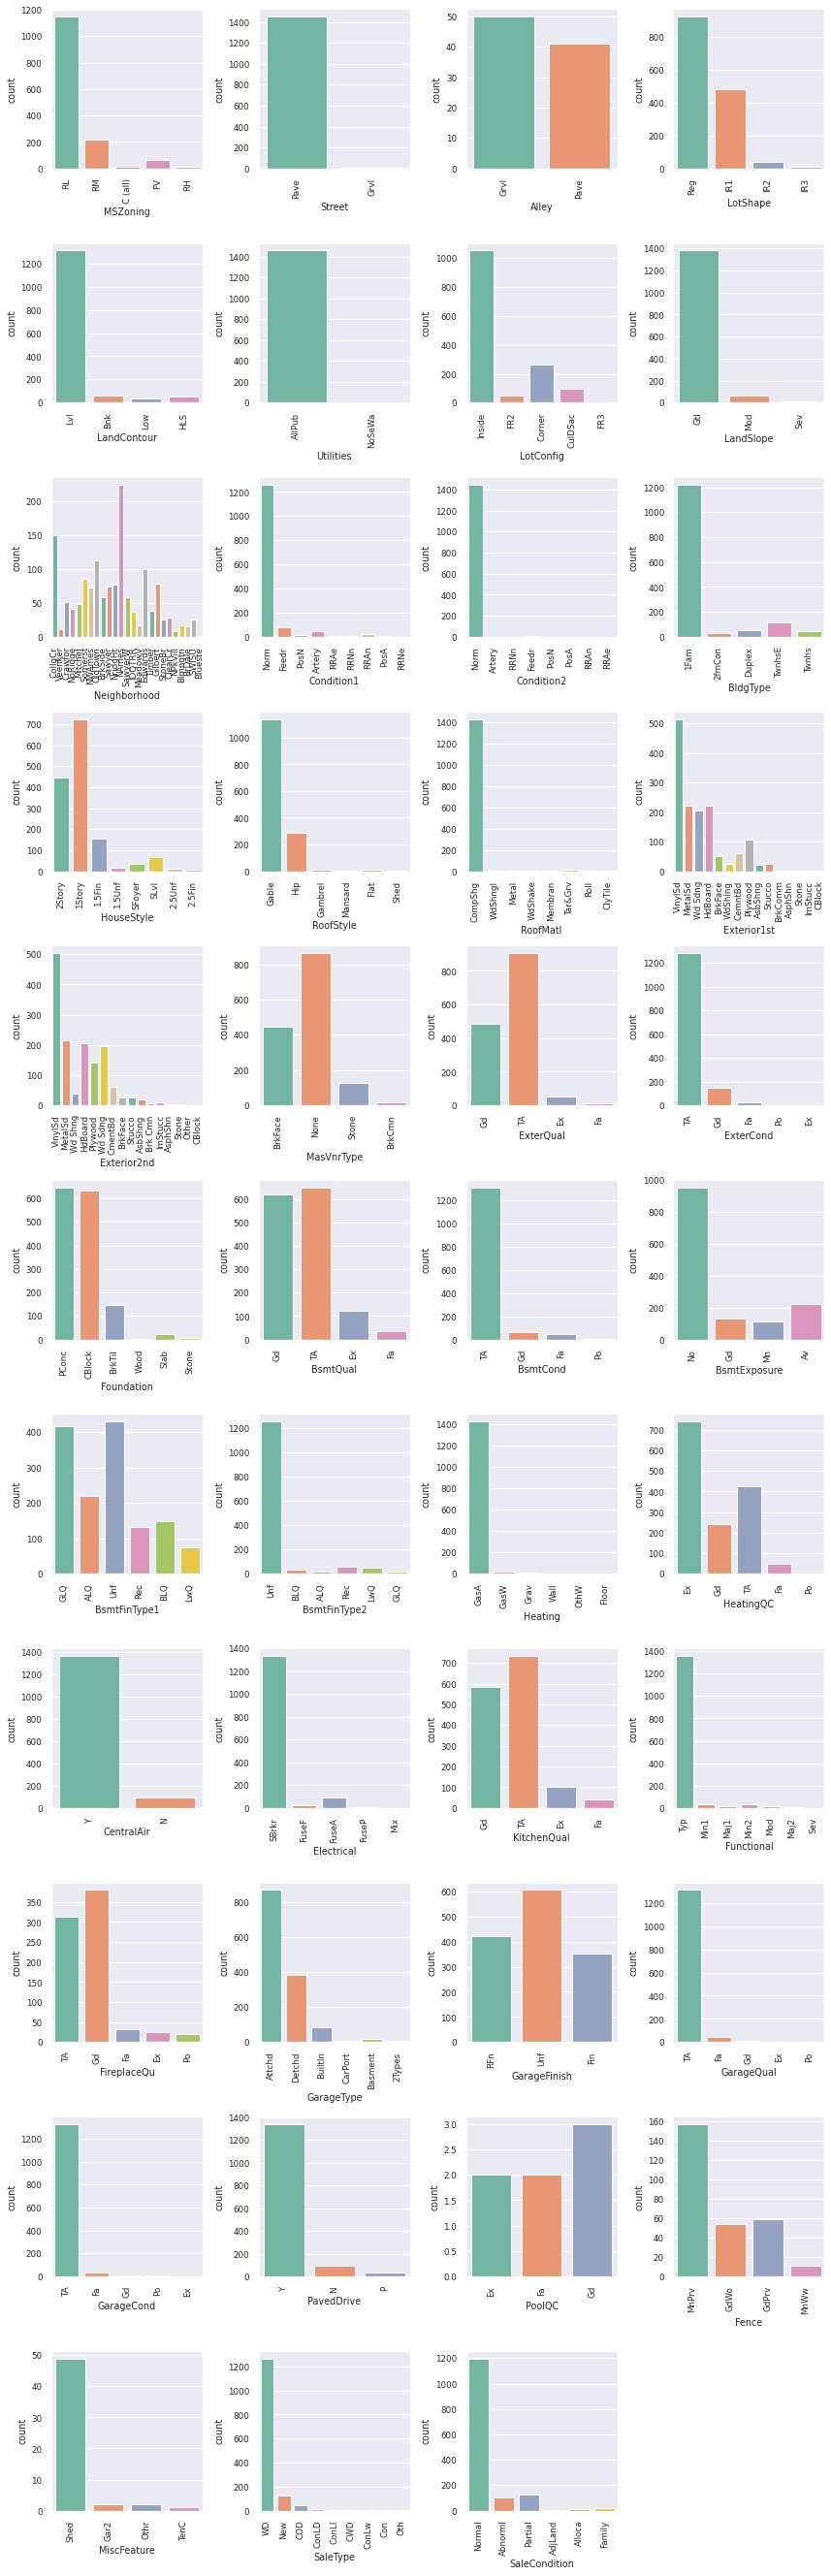

In [19]:
fig = plt.figure(figsize = (12, 37))

for index, column in enumerate(columns_cat):
    
    plt.subplot(11, 4, index + 1)
    sns.countplot(x = column, data = x_train, palette = 'Set2')
    plt.xticks(rotation = 90)
    
fig.tight_layout();

### Missing values

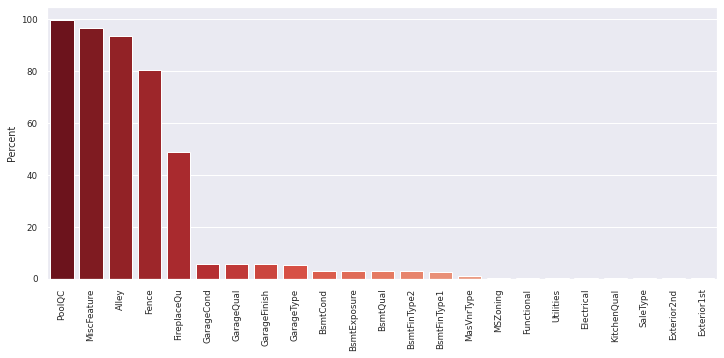

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,GarageCond,GarageQual,GarageFinish,GarageType,BsmtCond,BsmtExposure,BsmtQual,BsmtFinType2,BsmtFinType1,MasVnrType,MSZoning,Functional,Utilities,Electrical,KitchenQual,SaleType,Exterior2nd,Exterior1st
Total,2909.0000,2814.0000,2721.0000,2348.0000,1420.0000,159.0000,159.0000,159.0000,157.0000,82.0000,82.0000,81.0000,80.0000,79.0000,24.0000,4.0000,2.0000,2.0000,1.0000,1.0000,1.0000,1.0000,1.0000
Percent,99.6574,96.4029,93.2169,80.4385,48.6468,5.4471,5.4471,5.4471,5.3786,2.8092,2.8092,2.7749,2.7407,2.7064,0.8222,0.1370,0.0685,0.0685,0.0343,0.0343,0.0343,0.0343,0.0343


In [20]:
df_missing = missing_percentage(x_total[columns_cat])
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x=df_missing.index, y='Percent', data=df_missing, palette='Reds_r')
plt.xticks(rotation=90)
plt.show()
pd.set_option('precision', 4)
display(df_missing.T.style.background_gradient(cmap='Reds', axis=1))

### Correlatioin

In [23]:
x = x_train.copy()
corr = {}
for col in columns_cat:
    x.fillna('None', inplace=True)
    cat_values = {}
    for val in x[col].unique():
        cat_values[val] = y_train[x[col] == val].values
    corr[col] = 1 - stats.kruskal(*list(cat_values.values())).pvalue

corr = sorted(corr.items(), key=lambda x: x[1], reverse=False)
df_corr = pd.DataFrame(data=corr, columns=['Feature', 'PValue'])
df_corr = df_corr.set_index('Feature')
display(df_corr.T.style.background_gradient(cmap='Reds', axis=1))

Feature,Utilities,LandSlope,PoolQC,Street,MiscFeature,Condition2,RoofMatl,Functional,Heating,LotConfig,RoofStyle,LandContour,ExterCond,Alley,BsmtFinType2,Condition1,BldgType,Fence,MSZoning,LotShape,Neighborhood,HouseStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,HeatingQC,CentralAir,Electrical,KitchenQual,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
PValue,0.4767,0.8605,0.8882,0.9199,0.9794,0.9870,0.9914,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


---
## Explore the target variable

Skewness: 1.88
Kurtosis: 6.54


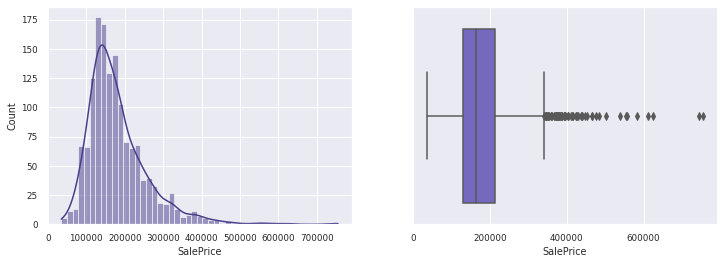

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

sns.histplot(data=y_train, color='darkslateblue', ax = ax1, kde=True)
sns.boxplot(x=y_train, color='slateblue', ax = ax2)
ax2.set_xticks([0, 200000, 400000, 600000])

#skewness and kurtosis
print('Skewness: {}'.format( np.round(y_train.skew(), 2) ))
print('Kurtosis: {}'.format( np.round(y_train.kurt(), 2) ))

Our target variable deviates from the symmetrical bell curve we would expect from a normal distribution. Specifically, it is right-skewed (similar terms: right-tailed or skewed to the right) since the right tail is longer.

This could be a problem since many ML algorithms don't do well with data that are not normally distributed. We can correct for this by performing a **log-transformation** of the target variable:

Skewness: 0.12
Kurtosis: 0.81


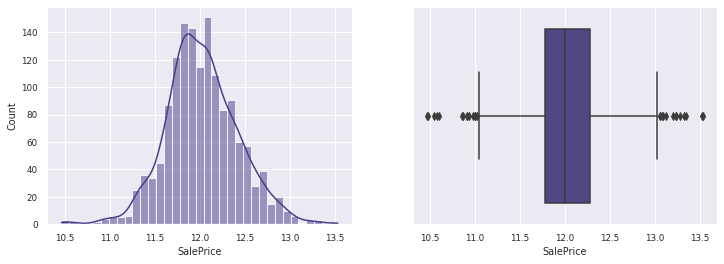

In [25]:
y_train_transformed = np.log1p(y_train)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

sns.histplot(data=y_train_transformed, color = 'darkslateblue', ax = ax1, kde=True)
sns.boxplot(x=y_train_transformed, color = 'darkslateblue', ax = ax2)

#skewness and kurtosis
print('Skewness: {}'.format( np.round(y_train_transformed.skew(), 2) ))
print('Kurtosis: {}'.format( np.round(y_train_transformed.kurt(), 2) ))